<a href="https://colab.research.google.com/github/Alisha-suresh/DISSERTATION-COMBINE/blob/INTEGRATION/scripts/fake_news_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# General imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import joblib

# TensorFlow and DistilBERT imports
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.callbacks import ModelCheckpoint

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
# Warnings
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [36]:
# # Check if GPU is available
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# device_name = tf.test.gpu_device_name()
# if "GPU" not in device_name:
#     raise SystemError('GPU device not found')

In [37]:
# Load the preprocessed data
# data_path = '../datasets/MC-Fake2/mc_fake2_small.csv'  # Adjust path as necessary
df = pd.read_csv("mc_fake2_small.csv")

# Display basic information about the dataset
print("Loaded preprocessed data:")
print(df.info())
print(df.head())

# Separate features and labels
X = df['text']
y = df['labels']

# Handling class imbalance by computing class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")

Loaded preprocessed data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2813 entries, 0 to 2812
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        2813 non-null   object 
 1   title       2813 non-null   object 
 2   labels      2813 non-null   int64  
 3   n_tweets    2813 non-null   float64
 4   n_retweets  2813 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 110.0+ KB
None
                                                text  \
0  Not long after announcing she was taking an "i...   
1  I get it: Sometimes you want loose, undone wav...   
2  How does obesity, smoking factor into coronavi...   
3  Latina influencer Massy Arias gets real about ...   
4   (CNN)What are people doing with all that Bitc...   

                                               title  labels  n_tweets  \
0  Britney Spears Addresses Mental Health Rumors ...       0 -0.315069   
1       how to get beach wa

In [38]:
# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# # Tokenize the text
# def tokenize_text(texts):
#     return tokenizer(
#         texts.tolist(),
#         max_length=128,
#         padding='max_length',
#         truncation=True,
#         return_tensors='tf'
#     )

# # Tokenize the training and test data
# print("Tokenizing text data...")
# X_train_tokenized = tokenize_text(X_train)
# X_test_tokenized = tokenize_text(X_test)
# print("Text data tokenized.")
# Tokenize the text in batches
def tokenize_text_in_batches(texts, batch_size=100):
    tokenized = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokenized_batch = tokenizer(
            batch_texts.tolist(),
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        tokenized.append(tokenized_batch)
    return tokenized

print("Tokenizing text data...")
X_train_tokenized_batches = tokenize_text_in_batches(X_train)
X_test_tokenized_batches = tokenize_text_in_batches(X_test)
print("Text data tokenized.")

Tokenizing text data...
Text data tokenized.


In [39]:
# Load the DistilBERT model
print("Loading DistilBERT model...")
distilbert_base = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Define a custom model class for DistilBERT
class CustomDistilBERTModel(tf.keras.Model):
    def __init__(self, distilbert):
        super(CustomDistilBERTModel, self).__init__()
        self.distilbert = distilbert
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(64, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooling(distilbert_output[0])
        x = self.dense(pooled_output)
        x = self.dropout(x, training=training)
        return self.output_layer(x)

# Initialize the custom DistilBERT model
print("Initializing custom DistilBERT model...")
distilbert_model = CustomDistilBERTModel(distilbert_base)

# Build the model
sample_input = {name: tf.zeros((1, 128), dtype=tf.int32) for name in ['input_ids', 'attention_mask']}
_ = distilbert_model(sample_input)

# Summary of the model
distilbert_model.summary()



Loading DistilBERT model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Initializing custom DistilBERT model...


Model: "custom_distil_bert_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ global_average_pooling1d_3           │ (1, 768)                    │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 64)                     │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# # Apply PCA to reduce dimensionality
# print("Applying PCA to reduce dimensionality...")
# pca = PCA(n_components=50)
# X_train_pca = pca.fit_transform(X_train_tokenized['input_ids'].numpy())
# X_test_pca = pca.transform(X_test_tokenized['input_ids'].numpy())
# print("PCA applied.")

# Apply PCA to reduce dimensionality
print("Applying PCA to reduce dimensionality...")
X_train_pca_batches = []
X_test_pca_batches = []

pca = PCA(n_components=50)

for tokenized_batch in X_train_tokenized_batches:
    pca_batch = pca.fit_transform(tokenized_batch['input_ids'].numpy())
    X_train_pca_batches.append(pca_batch)

for tokenized_batch in X_test_tokenized_batches:
    pca_batch = pca.transform(tokenized_batch['input_ids'].numpy())
    X_test_pca_batches.append(pca_batch)

print("PCA applied.")


Applying PCA to reduce dimensionality...
PCA applied.


Training Linear SVC...
Linear SVC trained.
Evaluating Linear SVC...
Linear SVC Accuracy: 0.5027, F1-Score: 0.5677
Training Logistic Regression...
Logistic Regression trained.
Evaluating Logistic Regression...
Logistic Regression Evaluation Metrics:
Accuracy: 0.4618
Precision: 0.7051
Recall: 0.4618
F1-score: 0.5300
Confusion Matrix:
[[219 253]
 [ 50  41]]



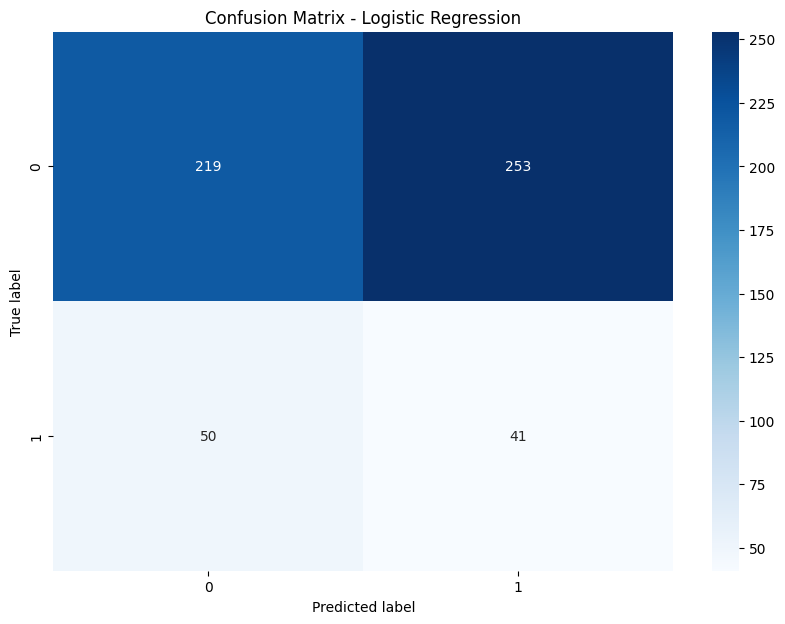

Training Random Forest...
Random Forest trained.
Evaluating Random Forest...
Random Forest Evaluation Metrics:
Accuracy: 0.8384
Precision: 0.7029
Recall: 0.8384
F1-score: 0.7647
Confusion Matrix:
[[472   0]
 [ 91   0]]



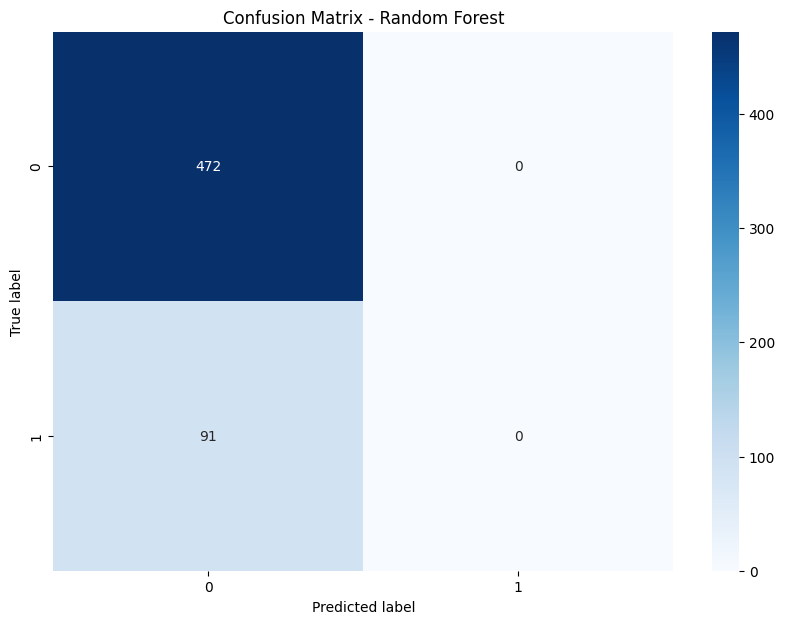

Training XGBoost...
XGBoost trained.
Evaluating XGBoost...
XGBoost Evaluation Metrics:
Accuracy: 0.8330
Precision: 0.7021
Recall: 0.8330
F1-score: 0.7620
Confusion Matrix:
[[469   3]
 [ 91   0]]



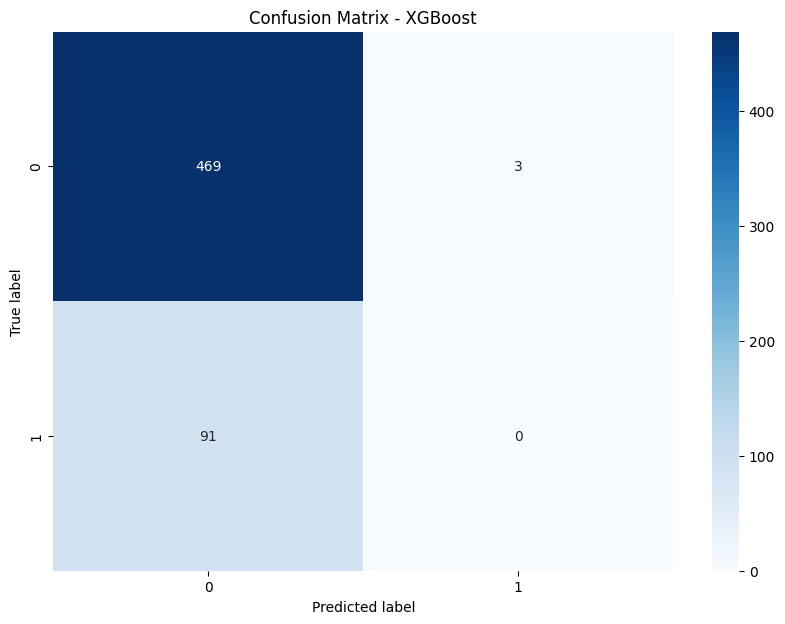

All models trained and evaluated.


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Train Linear SVC with batch processing
def train_linear_svc(X_train_batches, y_train, X_test_batches, y_test):
    print("Training Linear SVC...")
    svc = LinearSVC(class_weight='balanced')
    all_train_features = np.vstack(X_train_batches)
    all_test_features = np.vstack(X_test_batches)

    svc.fit(all_train_features, y_train)

    print("Linear SVC trained.")

    print("Evaluating Linear SVC...")
    y_pred = svc.predict(all_test_features)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Linear SVC Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

    return svc

svc_model = train_linear_svc(X_train_pca_batches, y_train, X_test_pca_batches, y_test)

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print(f"{model_name} trained.")

    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print()

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes=np.unique(y_test), title=f'Confusion Matrix - {model_name}')

    return model

# Train models
logreg = LogisticRegression(max_iter=100, class_weight='balanced')
logreg = train_and_evaluate(logreg, np.vstack(X_train_pca_batches), y_train, np.vstack(X_test_pca_batches), y_test, "Logistic Regression")

random_forest = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
random_forest = train_and_evaluate(random_forest, np.vstack(X_train_pca_batches), y_train, np.vstack(X_test_pca_batches), y_test, "Random Forest")

xgb = XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False)
xgb = train_and_evaluate(xgb, np.vstack(X_train_pca_batches), y_train, np.vstack(X_test_pca_batches), y_test, "XGBoost")

print("All models trained and evaluated.")

In [42]:
# Cross-validation and hyperparameter tuning (commented out for now)
# """
# # Example of cross-validation and hyperparameter tuning

# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1]
# }

# grid_search = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=3)
# grid_search.fit(X_train_pca, y_train)

# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best CV Score: {grid_search.best_score_}")

Starting model evaluation...
Evaluating Logistic Regression model...
Logistic Regression Evaluation Metrics:
Accuracy: 0.4618
Precision: 0.7051
Recall: 0.4618
F1-Score: 0.5300
Confusion Matrix:
[[219 253]
 [ 50  41]]



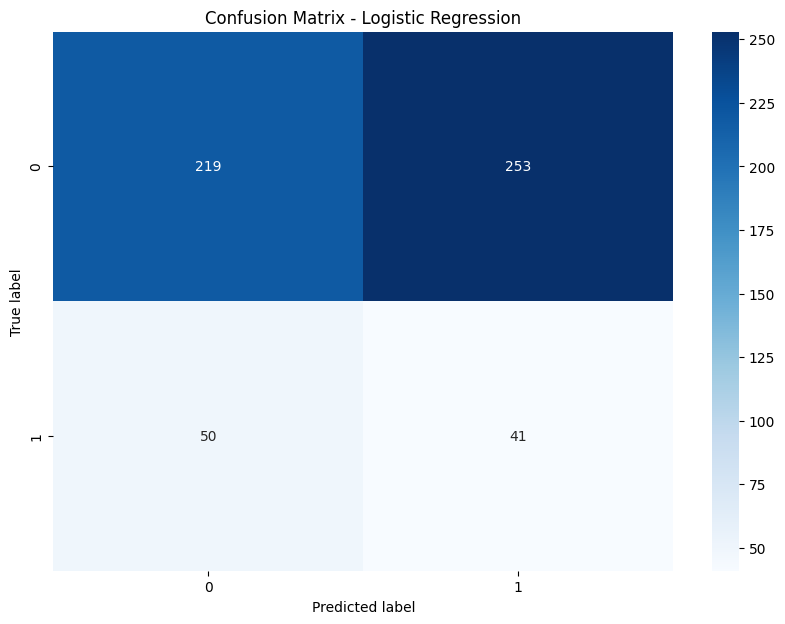

Evaluating Random Forest model...
Random Forest Evaluation Metrics:
Accuracy: 0.8384
Precision: 0.7029
Recall: 0.8384
F1-Score: 0.7647
Confusion Matrix:
[[472   0]
 [ 91   0]]



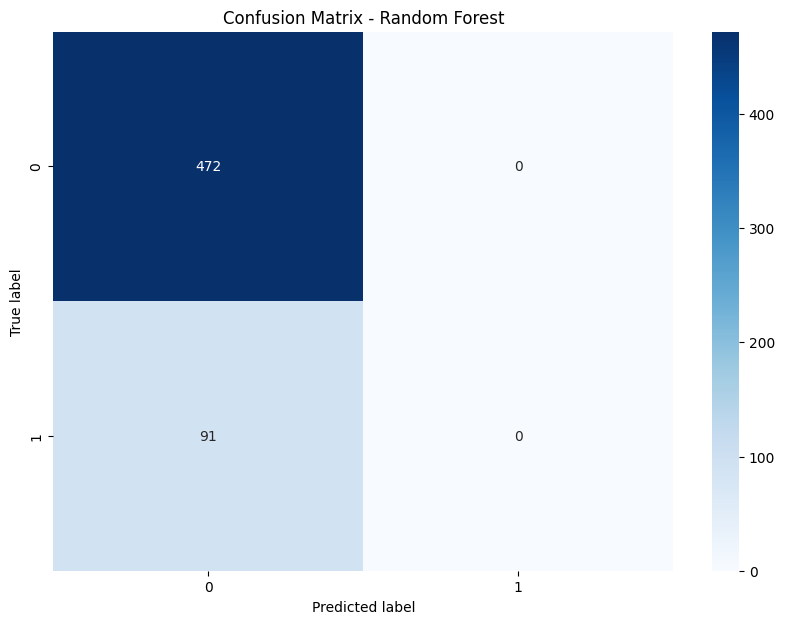

Evaluating XGBoost model...
XGBoost Evaluation Metrics:
Accuracy: 0.8330
Precision: 0.7021
Recall: 0.8330
F1-Score: 0.7620
Confusion Matrix:
[[469   3]
 [ 91   0]]



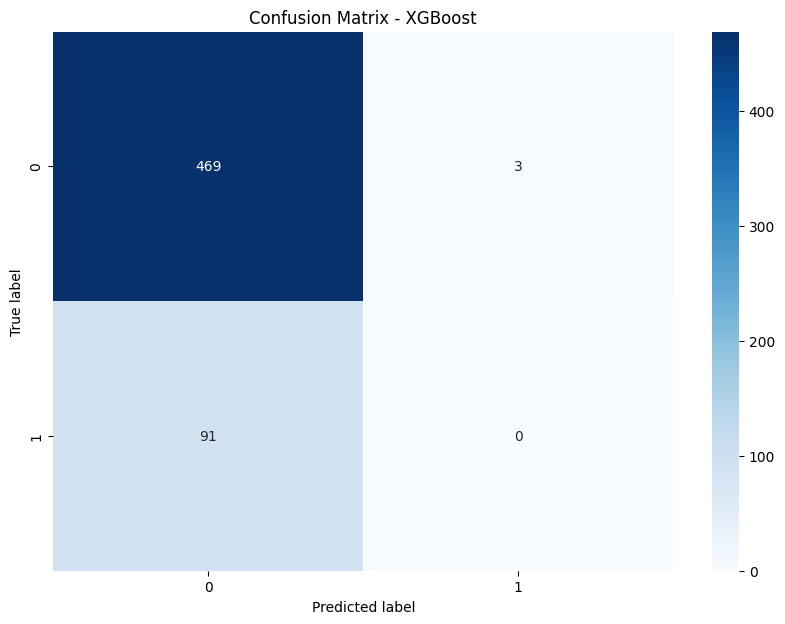

Evaluating LinearSVC model...
LinearSVC Evaluation Metrics:
Accuracy: 0.5027
Precision: 0.7193
Recall: 0.5027
F1-Score: 0.5677
Confusion Matrix:
[[242 230]
 [ 50  41]]



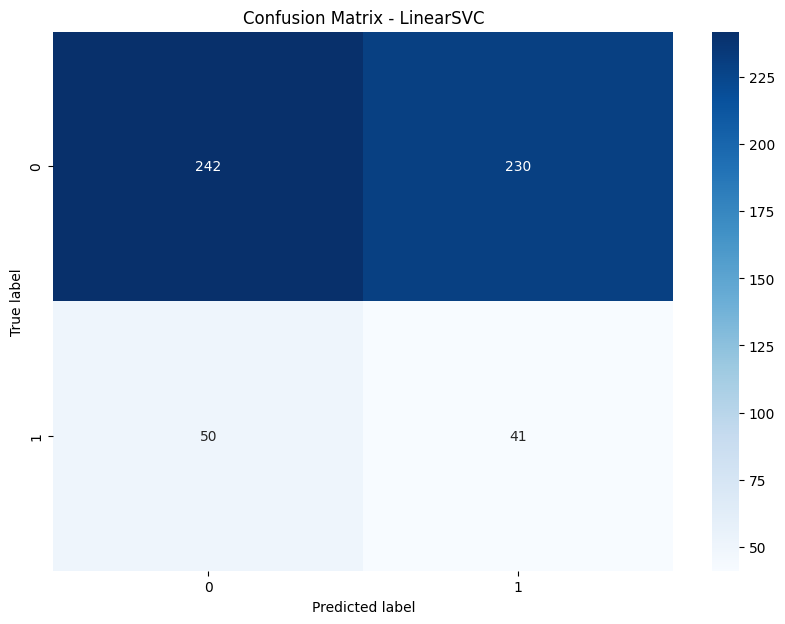

Evaluating DistilBERT model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
DistilBERT Evaluation Metrics:
Accuracy: 0.1652
Precision: 0.6548
Recall: 0.1652
F1-Score: 0.0553
Confusion Matrix:
[[  3 469]
 [  1  90]]



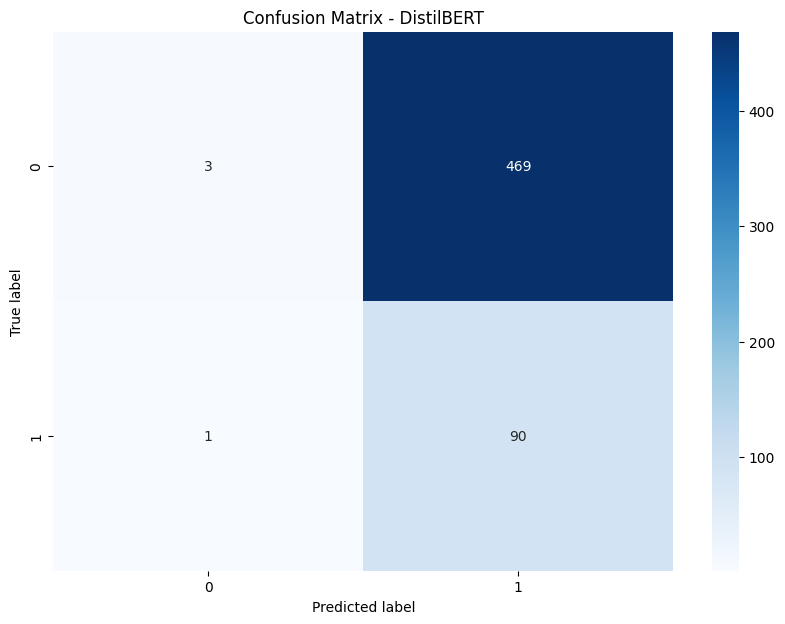

Creating and evaluating Ensemble model...
Generating ensemble predictions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Ensemble predictions generated.
Ensemble Evaluation Metrics:
Accuracy: 0.6270
Precision: 0.7156
Recall: 0.6270
F1-Score: 0.6645
Confusion Matrix:
[[331 141]
 [ 69  22]]



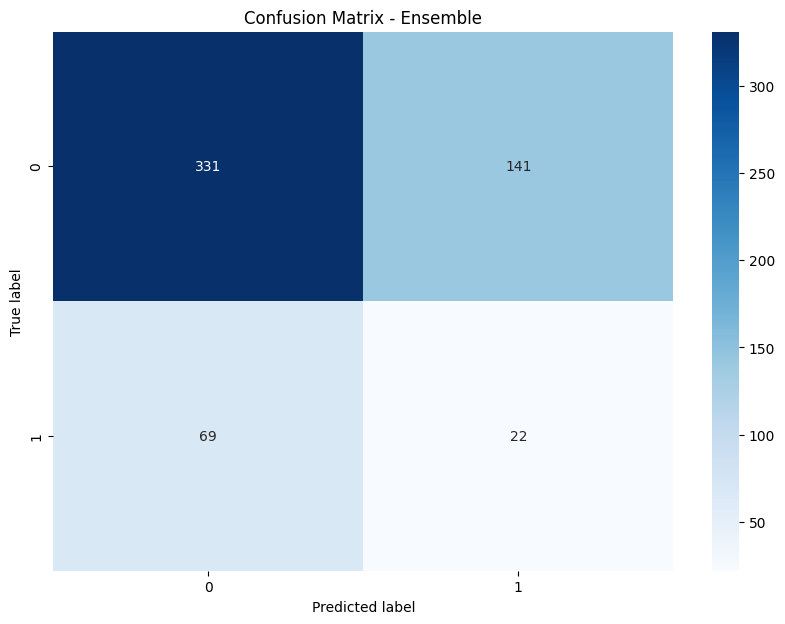


Best model: Random Forest with Accuracy: 0.8384


In [50]:
from sklearn.metrics import f1_score
import tensorflow as tf

# Adjust the evaluate_model function to work correctly with both individual and batch processing
def evaluate_model(model, X_test_batches, y_test, model_name):
    all_preds = []

    if model_name == "Ensemble":
        all_preds = X_test_batches[0]
    else:
        for tokenized_batch in X_test_batches:
            if model_name == 'DistilBERT':
                input_dict = {name: tf.constant(tensor) for name, tensor in tokenized_batch.items()}
                batch_preds = model.predict(input_dict)
                batch_preds = (batch_preds > 0.5).astype(int).squeeze()
            else:
                batch_preds = model.predict(tokenized_batch)

            all_preds.append(batch_preds)

        all_preds = np.concatenate(all_preds, axis=0)

    accuracy = accuracy_score(y_test, all_preds)
    precision = precision_score(y_test, all_preds, average='weighted')
    recall = recall_score(y_test, all_preds, average='weighted')
    f1 = f1_score(y_test, all_preds, average='weighted')
    cm = confusion_matrix(y_test, all_preds)

    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print()

    plot_confusion_matrix(cm, classes=np.unique(y_test), title=f'Confusion Matrix - {model_name}')

    return all_preds, accuracy

def get_ensemble_predictions(models, X_test_pca_batches, X_test_tokenized_batches, weights=None):
    print("Generating ensemble predictions...")
    all_preds = []

    # Process traditional models (Logistic Regression, Random Forest, XGBoost, LinearSVC)
    for name, model in models.items():
        if name != 'DistilBERT':
            batch_preds = []
            for batch in X_test_pca_batches:
                preds = model.predict(batch)
                batch_preds.append(preds)
            model_preds = np.concatenate(batch_preds)
            all_preds.append(model_preds)

    # Process DistilBERT separately
    distilbert_preds = []
    for batch in X_test_tokenized_batches:
        input_dict = {name: tf.constant(tensor) for name, tensor in batch.items()}
        preds = models['DistilBERT'].predict(input_dict)
        preds = (preds > 0.5).astype(int).squeeze()
        distilbert_preds.append(preds)
    distilbert_preds = np.concatenate(distilbert_preds)
    all_preds.append(distilbert_preds)

    all_preds = np.array(all_preds)

    # Ensure weights match the number of models
    if weights is None or len(weights) != len(all_preds):
        weights = np.ones(len(all_preds)) / len(all_preds)

    weighted_preds = np.average(all_preds, axis=0, weights=weights)
    ensemble_preds = (weighted_preds > 0.5).astype(int)

    print("Ensemble predictions generated.")
    return ensemble_preds

# Evaluate all models including the ensemble
print("Starting model evaluation...")
models = {
    'Logistic Regression': logreg,
    'Random Forest': random_forest,
    'XGBoost': xgb,
    'LinearSVC': svc_model,
    'DistilBERT': distilbert_model
}

best_model = None
best_accuracy = 0
all_preds = {}

# Iterate over all models
for name, model in models.items():
    print(f"Evaluating {name} model...")
    if name == 'DistilBERT':
        preds, accuracy = evaluate_model(model, X_test_tokenized_batches, y_test, name)
    else:
        preds, accuracy = evaluate_model(model, X_test_pca_batches, y_test, name)

    all_preds[name] = preds

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, model)

# Create ensemble model
print("Creating and evaluating Ensemble model...")
weights = [0.20, 0.20, 0.20, 0.20, 0.20]  # Adjust the weights according to the number of models

# Generate ensemble predictions
ensemble_preds = get_ensemble_predictions(models, X_test_pca_batches, X_test_tokenized_batches, weights)

# Evaluate the ensemble model
_, ensemble_accuracy = evaluate_model(None, [ensemble_preds], y_test, "Ensemble")

# Check if the ensemble model is the best-performing model
if ensemble_accuracy > best_accuracy:
    best_accuracy = ensemble_accuracy
    best_model = ("Ensemble", ensemble_preds)

# Final results
print(f"\nBest model: {best_model[0]} with Accuracy: {best_accuracy:.4f}")


In [51]:
import joblib
import tensorflow as tf
import os

# Save the best-performing model
print(f"Saving the best-performing model: {best_model[0]}")
model_save_dir = 'best_fake_news_model'
os.makedirs(model_save_dir, exist_ok=True)

if best_model[0] == 'Ensemble':
    ensemble_models = {
        'DistilBERT': distilbert_model,
        'Logistic Regression': logreg,
        'Random Forest': random_forest,
        'XGBoost': xgb
    }
    ensemble_weights = weights
    joblib.dump(ensemble_models, os.path.join(model_save_dir, 'ensemble_models.joblib'))
    joblib.dump(ensemble_weights, os.path.join(model_save_dir, 'ensemble_weights.joblib'))
    print(f"Ensemble models and weights saved to {model_save_dir}")
elif best_model[0] == 'DistilBERT':
    model_save_path = os.path.join(model_save_dir, 'distilbert_model')
    best_model[1].save(model_save_path)
    print(f"DistilBERT model saved to {model_save_path}")
else:
    model_save_path = os.path.join(model_save_dir, f'{best_model[0].lower().replace(" ", "_")}_model.joblib')
    joblib.dump(best_model[1], model_save_path)
    print(f"{best_model[0]} model saved to {model_save_path}")

# Save model information
model_info = {
    'best_model_name': best_model[0],
    'best_accuracy': best_accuracy
}
joblib.dump(model_info, os.path.join(model_save_dir, 'model_info.joblib'))
print(f"Model information saved to {os.path.join(model_save_dir, 'model_info.joblib')}")

Saving the best-performing model: Random Forest
Random Forest model saved to best_fake_news_model/random_forest_model.joblib
Model information saved to best_fake_news_model/model_info.joblib


In [ ]:
!ls -lh best_fake_news_model


In [52]:
!zip -r best_fake_news_model.zip best_fake_news_model
from google.colab import files
files.download('best_fake_news_model.zip')


updating: best_fake_news_model/ (stored 0%)
updating: best_fake_news_model/random_forest_model.joblib (deflated 75%)
updating: best_fake_news_model/model_info.joblib (deflated 12%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>